In [1]:
import pandas as pd
import numpy as np
from datetime import datetime


In [2]:
def update_df_columns(df):
    df['Time'] = df['Time'].apply(lambda x: datetime.utcfromtimestamp(int(x) / 1e6).strftime("%H:%M:%S.%f")[:-3])
    acceleration_columns = ['ACC-X', 'ACC-Y', 'ACC-Z']
    df['Magnitude'] = np.linalg.norm(df[acceleration_columns], axis=1)
    return df

In [3]:
def time_difference(df):
    
    #Check time difference
    first_timestamp = datetime.strptime(df['Time'].iloc[0], "%H:%M:%S.%f")
    last_timestamp = datetime.strptime(df['Time'].iloc[-1], "%H:%M:%S.%f")

    # Calculate time difference
    time_difference = last_timestamp - first_timestamp

    # Print the results
    print("Time Difference:", time_difference.total_seconds(), "seconds")

In [4]:
def high_avg_magnitude(df, activity):
    print('---'*30)
    print("High and Low Magnitude while ", activity)
    print("Average Magnitude:", df['Magnitude'].mean())
    print('---'*30)
    print(df.nlargest(10, 'Magnitude'))
    print(df.nsmallest(10, 'Magnitude'))


In [ ]:

# Specify the path to your CSV file
active_daily = "imu-dataset/sub1/ADLs/AXR_AS_trial1.xlsx"
fall = "imu-dataset/sub1/Falls/AXR_ITCS_trial3.xlsx"
near_fall = "imu-dataset/sub1/Near_Falls/AXR_ITCS_trial6.xlsx"

# Load the CSV file into a Pandas DataFrame
df_adl = pd.read_excel(active_daily)
df_fall = pd.read_excel(fall)
df_near_fall = pd.read_excel(near_fall)

df_adl = update_df_columns(df_adl)
df_fall = update_df_columns(df_fall)
df_near_fall = update_df_columns(df_near_fall)

time_difference(df_adl)
time_difference(df_fall)
time_difference(df_near_fall)

# Print the top 5 rows with the highest 'magnitude' values
high_avg_magnitude(df_adl, "active daily living")
high_avg_magnitude(df_fall, "fall")
high_avg_magnitude(df_near_fall, "near fall")

print('---'*30)

df_adl.shape[0]

In [5]:
import matplotlib.pyplot as plt

def draw_graph(ax, df, title):
    # Plotting the graph on the given axis
    ax.plot(df['Time'], df['Magnitude'])
    ax.set_title(f'Time vs Magnitude ({title})')
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Magnitude')




In [ ]:
# Create a figure with subplots
fig, axs = plt.subplots(1, 3, figsize=(18, 6))
fig.suptitle('Different kinds of Fall Detection')

# Plot each graph on its own subplot
draw_graph(axs[0], df_adl, 'active daily')
draw_graph(axs[1], df_fall, 'fall')
draw_graph(axs[2], df_near_fall, 'near fall')

# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [10]:
lift_file = "sample-data/ACG-lift.csv"
df_lift = pd.read_csv(lift_file, delimiter=";")

rename_columns = {'t_unix':'Time', 'x':'ACC-X', 'y':'ACC-Y', 'z':'ACC-Z'}
df_lift.rename(columns=rename_columns, inplace=True)
df_lift.drop(columns={'t_Android', 'a'}, inplace=True)

df_lift = update_df_columns(df_lift)

time_difference(df_lift)

# Print the top 5 rows with the highest 'magnitude' values
high_avg_magnitude(df_lift, "elevator")

print('---'*30)


Time Difference: 0.139 seconds
------------------------------------------------------------------------------------------
High and Low Magnitude while  elevator
Average Magnitude: 9.892087712897883
------------------------------------------------------------------------------------------
              Time     ACC-X     ACC-Y      ACC-Z  Magnitude
7664  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7665  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7666  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7667  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7668  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7669  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7670  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7671  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7672  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
7673  18:03:12.886 -1.956063  3.442862  10.790668  11.494259
               Time     ACC-X     ACC-Y 

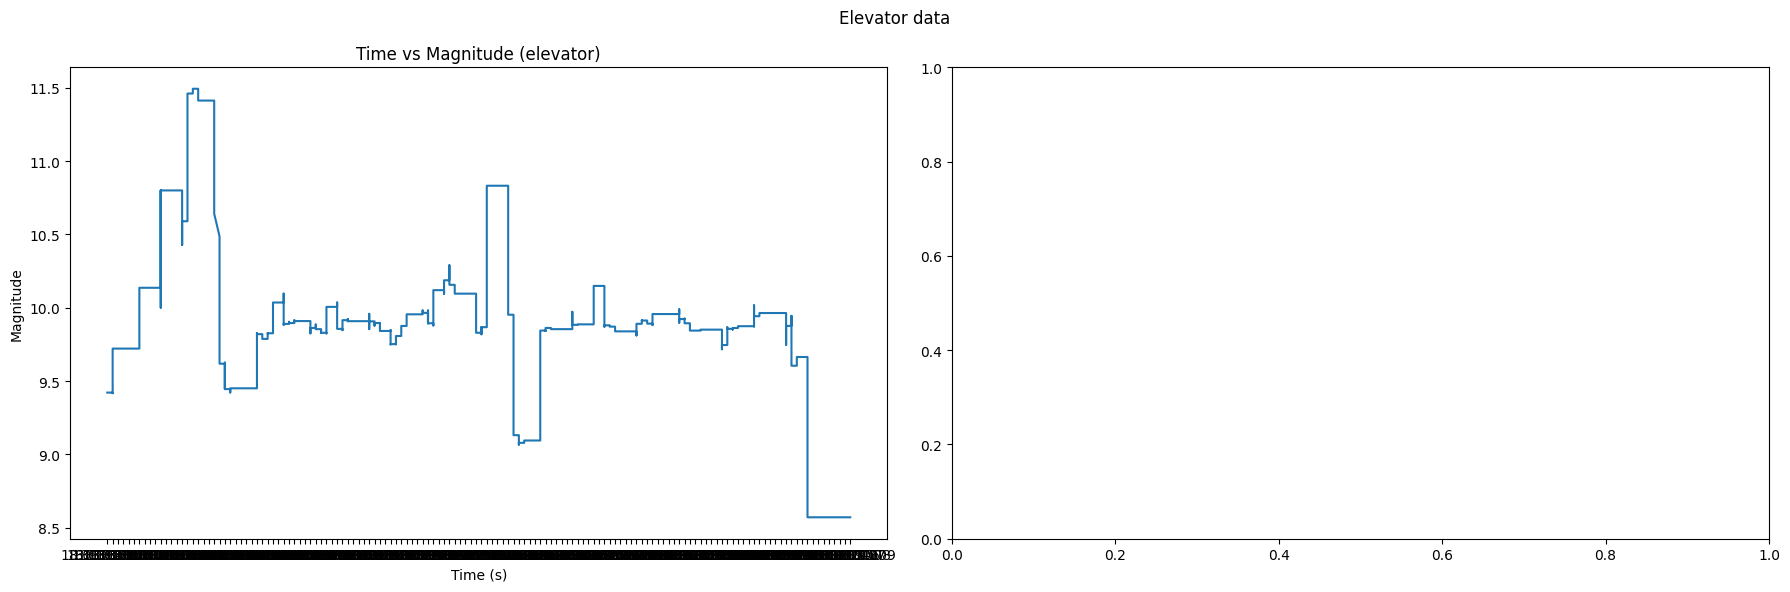

In [13]:
fig, axs = plt.subplots(1, 2, figsize=(18, 6))
fig.suptitle('Elevator data')

# Plot each graph on its own subplot
draw_graph(axs[0], df_lift, 'elevator')


# Adjust layout for better spacing
plt.tight_layout()
plt.show()


In [3]:
import pandas as pd

def calculate_zcr(signal):
    # Check if the signal is empty or has only one element
    if len(signal) < 2:
        return 0.0
    
    # Count the number of times the signal changes its sign
    zcr = ((signal[:-1] * signal[1:]) < 0).sum()
    
    # Normalize by the length of the signal
    zcr /= len(signal) - 1
    
    return zcr

def add_zcr_to_dataset(df):
    # Calculate ZCR for each axis
    df['ZCR_X'] = df['X'].apply(calculate_zcr)
    df['ZCR_Y'] = df['Y'].apply(calculate_zcr)
    df['ZCR_Z'] = df['Z'].apply(calculate_zcr)
    
    # Optionally, you can calculate ZCR for the magnitude of the acceleration vector
    df['Magnitude'] = (df['X']**2 + df['Y']**2 + df['Z']**2)**0.5
    df['ZCR_Magnitude'] = df['Magnitude'].apply(calculate_zcr)
    
    # Drop the 'Magnitude' column if you don't need it in your dataset
    df = df.drop(columns=['Magnitude'], errors='ignore')
    
    return df

# Example usage
# Assume 'your_data' is your Pandas DataFrame containing 'Time', 'X', 'Y', and 'Z' columns
# Make sure 'Time' column is in datetime format
your_data = pd.DataFrame({'Time': ['2024-01-31 12:00:00', '2024-01-31 12:01:00', '2024-01-31 12:02:00'],
                          'X': [1.2, 1.5, 2.0],
                          'Y': [0.8, 1.0, 1.2],
                          'Z': [1.0, 1.2, 1.5]})

# Add ZCR to the dataset
your_data_with_zcr = add_zcr_to_dataset(your_data)

# Display the resulting DataFrame
print(your_data_with_zcr)


TypeError: object of type 'float' has no len()